
Identification

Name: Luan Carlos da Silva Casagrande - 12630405

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from random import shuffle
import torch
from torch import nn
import math
from glob import glob
import sys
import shutil  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

%matplotlib inline

cpu


# data loader

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
import torchvision.transforms as transforms
import PIL
import random
from scipy import ndimage
from skimage import io

class segDataset(torch.utils.data.Dataset):
    def __init__(self, root, training, transform=None):
        super(segDataset, self).__init__()
        self.root = root
        self.training = training
        self.transform = transform
        self.IMG_NAMES = sorted(glob(self.root + '/*/images/*.png'))
        print(self.IMG_NAMES, self.root + '/*/images/*.png')
        self.BGR_classes = {'Water' : [226, 169, 41],
                            'Land' : [132,  41, 246],
                            'Road' : [110, 193, 228],
                            'Unlabeled' : [155, 155, 155]} # in BGR

        self.bin_classes = ['Water', 'Land', 'Road', 'Unlabeled']


    def __getitem__(self, idx):
        img_path = self.IMG_NAMES[idx]
        mask_path = img_path.replace('images', 'masks').replace('.png', '.png')

        image = io.imread(img_path)
        mask = cv2.imread(mask_path)

        cls_mask = np.zeros(mask.shape)  
        cls_mask[mask == self.BGR_classes['Water']] = self.bin_classes.index('Water')
        cls_mask[mask == self.BGR_classes['Land']] = self.bin_classes.index('Land')
        cls_mask[mask == self.BGR_classes['Road']] = self.bin_classes.index('Road')
        cls_mask[mask == self.BGR_classes['Unlabeled']] = self.bin_classes.index('Unlabeled')
        cls_mask = cls_mask[:,:,0] 

        if self.training==True:
            if self.transform:
              image = transforms.functional.to_pil_image(image)
              image = self.transform(image)
              image = np.array(image)

            # 90 degree rotation
            if np.random.rand()<0.5:
              angle = np.random.randint(4) * 90
              image = ndimage.rotate(image,angle,reshape=True)
              cls_mask = ndimage.rotate(cls_mask,angle,reshape=True)

            # vertical flip
            if np.random.rand()<0.5:
              image = np.flip(image, 0)
              cls_mask = np.flip(cls_mask, 0)
            
            # horizonal flip
            if np.random.rand()<0.5:
              image = np.flip(image, 1)
              cls_mask = np.flip(cls_mask, 1)

        image = cv2.resize(image, (512,512))/255.0
        cls_mask = cv2.resize(cls_mask, (512,512)) 
        image = np.moveaxis(image, -1, 0)

        return torch.tensor(image).float(), torch.tensor(cls_mask, dtype=torch.int64)


    def __len__(self):
        return len(self.IMG_NAMES)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
color_shift = transforms.ColorJitter(.1,.1,.1,.1)
blurriness = transforms.GaussianBlur(3, sigma=(0.1, 2.0))

t = transforms.Compose([color_shift, blurriness])
dataset = segDataset('drive/MyDrive/dataset-vis/train/', training = True, transform= None)

datasetTest = segDataset('drive/MyDrive/dataset-vis/test/', training = False, transform= None)

len(dataset)

['drive/MyDrive/dataset-vis/train/t1/images/0.png', 'drive/MyDrive/dataset-vis/train/t1/images/1.png', 'drive/MyDrive/dataset-vis/train/t1/images/10.png', 'drive/MyDrive/dataset-vis/train/t1/images/100.png', 'drive/MyDrive/dataset-vis/train/t1/images/1000.png', 'drive/MyDrive/dataset-vis/train/t1/images/1001.png', 'drive/MyDrive/dataset-vis/train/t1/images/1002.png', 'drive/MyDrive/dataset-vis/train/t1/images/1003.png', 'drive/MyDrive/dataset-vis/train/t1/images/1004.png', 'drive/MyDrive/dataset-vis/train/t1/images/1005.png', 'drive/MyDrive/dataset-vis/train/t1/images/1006.png', 'drive/MyDrive/dataset-vis/train/t1/images/1007.png', 'drive/MyDrive/dataset-vis/train/t1/images/1008.png', 'drive/MyDrive/dataset-vis/train/t1/images/1009.png', 'drive/MyDrive/dataset-vis/train/t1/images/101.png', 'drive/MyDrive/dataset-vis/train/t1/images/1010.png', 'drive/MyDrive/dataset-vis/train/t1/images/1011.png', 'drive/MyDrive/dataset-vis/train/t1/images/1012.png', 'drive/MyDrive/dataset-vis/train/t1/i

164

In [ ]:
test_num = int(0.1 * len(dataset))
print(f'test data : {test_num}')
train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [len(dataset)-test_num, test_num], generator=torch.Generator().manual_seed(101))

test data : 16


In [ ]:
BACH_SIZE = 4
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BACH_SIZE, shuffle=True, num_workers=4)

validation_dataloader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=BACH_SIZE, shuffle=False, num_workers=1)

test_dataloader = torch.utils.data.DataLoader(
    datasetTest, batch_size=BACH_SIZE, shuffle=False, num_workers=1)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# data sample

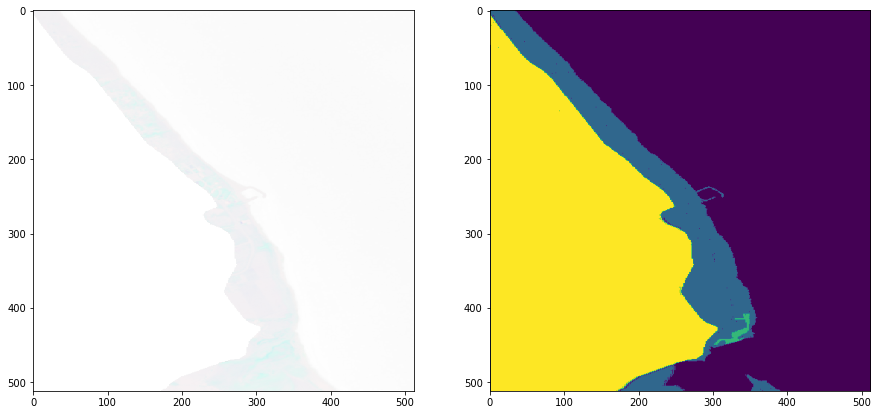

In [ ]:
d = dataset[0]
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(np.moveaxis(d[0].numpy(),0,-1))
plt.subplot(1,2,2)
plt.imshow(d[1].numpy())

# U-net model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

# Focal Loss definition

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input, dim=-1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [ ]:
criterion = FocalLoss(gamma=3/4).to(device)

# Jaccard loss definition

In [ ]:
class mIoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True, n_classes=2):
        super(mIoULoss, self).__init__()
        self.classes = n_classes

    def to_one_hot(self, tensor):
        n,h,w = tensor.size()
        one_hot = torch.zeros(n,self.classes,h,w).to(tensor.device).scatter_(1,tensor.view(n,1,h,w),1)
        return one_hot

    def forward(self, inputs, target):
        # inputs => N x Classes x H x W
        # target_oneHot => N x Classes x H x W

        N = inputs.size()[0]

        # predicted probabilities for each pixel along channel
        inputs = F.softmax(inputs,dim=1)
        
        # Numerator Product
        target_oneHot = self.to_one_hot(target)
        inter = inputs * target_oneHot
        ## Sum over all pixels N x C x H x W => N x C
        inter = inter.view(N,self.classes,-1).sum(2)

        #Denominator 
        union= inputs + target_oneHot - (inputs*target_oneHot)
        ## Sum over all pixels N x C x H x W => N x C
        union = union.view(N,self.classes,-1).sum(2)

        loss = inter/union

        ## Return average loss over classes and batch
        return 1-loss.mean()

In [ ]:
criterion = mIoULoss(n_classes=4).to(device)

# Training

In [ ]:
def acc(label, predicted):
  seg_acc = (y.cpu() == torch.argmax(pred_mask, axis=1).cpu()).sum() / torch.numel(y.cpu())
  return seg_acc

In [ ]:
min_loss = torch.tensor(float('inf'))

model = UNet(n_channels=4, n_classes=4, bilinear=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

In [ ]:
os.makedirs('drive/MyDrive/saved_mix', exist_ok=True)

N_EPOCHS = 40
N_DATA = len(train_dataset)


plot_losses = []
scheduler_counter = 0

for epoch in range(N_EPOCHS):
  # training
  model.train()
  loss_list = []
  acc_list = []
  for batch_i, (x, y) in enumerate(train_dataloader):

      pred_mask = model(x.to(device))  
      loss = criterion(pred_mask, y.to(device))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_list.append(loss.cpu().detach().numpy())
      acc_list.append(acc(y,pred_mask).numpy())

      sys.stdout.write(
          "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f)]"
          % (
              epoch,
              N_EPOCHS,
              batch_i,
              len(train_dataloader),
              loss.cpu().detach().numpy(),
              np.mean(loss_list),
          )
      )
  scheduler_counter += 1
  # testing
  model.eval()
  val_loss_list = []
  val_acc_list = []
  for batch_i, (x, y) in enumerate(test_dataloader):
      with torch.no_grad():    
          pred_mask = model(x.to(device))  
      val_loss = criterion(pred_mask, y.to(device))
      val_loss_list.append(val_loss.cpu().detach().numpy())
      val_acc_list.append(acc(y,pred_mask).numpy())
    
  print(' epoch {} - loss : {:.5f} - acc : {:.2f} - val loss : {:.5f} - val acc : {:.2f}'.format(epoch, 
                                                                                                 np.mean(loss_list), 
                                                                                                 np.mean(acc_list), 
                                                                                                 np.mean(val_loss_list),
                                                                                                 np.mean(val_acc_list)))
  plot_losses.append([epoch, np.mean(loss_list), np.mean(val_loss_list)])

  compare_loss = np.mean(val_loss_list)
  is_best = compare_loss < min_loss
  if is_best == True:
    scheduler_counter = 0
    min_loss = min(compare_loss, min_loss)
    torch.save(model.state_dict(), 'drive/MyDrive/saved_mix/unet_epoch_{}_{:.5f}.pt'.format(epoch,np.mean(val_loss_list)))
  
  if scheduler_counter > 5:
    lr_scheduler.step()
    print(f"lowering learning rate to {optimizer.param_groups[0]['lr']}")
    scheduler_counter = 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 0/100] [Batch 36/37] [Loss: 0.208154 (0.425389)] epoch 0 - loss : 0.42539 - acc : 0.80 - val loss : 0.37477 - val acc : 0.76
[Epoch 1/100] [Batch 36/37] [Loss: 0.352516 (0.322930)] epoch 1 - loss : 0.32293 - acc : 0.85 - val loss : 0.24983 - val acc : 0.90
[Epoch 2/100] [Batch 36/37] [Loss: 0.218359 (0.272866)] epoch 2 - loss : 0.27287 - acc : 0.87 - val loss : 0.36389 - val acc : 0.89
[Epoch 3/100] [Batch 36/37] [Loss: 0.358648 (0.278095)] epoch 3 - loss : 0.27810 - acc : 0.88 - val loss : 0.19797 - val acc : 0.90
[Epoch 4/100] [Batch 36/37] [Loss: 0.205419 (0.334243)] epoch 4 - loss : 0.33424 - acc : 0.84 - val loss : 0.32673 - val acc : 0.91
[Epoch 5/100] [Batch 36/37] [Loss: 0.169253 (0.318756)] epoch 5 - loss : 0.31876 - acc : 0.83 - val loss : 0.27158 - val acc : 0.87
[Epoch 6/100] [Batch 36/37] [Loss: 0.202862 (0.304795)] epoch 6 - loss : 0.30479 - acc : 0.87 - val loss : 0.17106 - val acc : 0.93
[Epoch 7/100] [Batch 36/37] [Loss: 0.279348 (0.269952)] epoch 7 - loss : 0.2

In [ ]:
# plot loss
plot_losses = np.array(plot_losses)
plt.plot(plot_losses[:,0], plot_losses[:,1], color='b', linewidth=4)
plt.plot(plot_losses[:,0], plot_losses[:,2], color='r', linewidth=4)
plt.title('FocalLoss', fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.ylabel('loss',fontsize=20)
plt.grid()
plt.legend(['training', 'validation']) # using a named size
plt.show()

# testing

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/saved_mix/unet_epoch_20_0.11873.pt', map_location=torch.device(device)))

<All keys matched successfully>

In [ ]:
def mIOU(label, pred, maskAux, num_classes=19):
    iou_list = list()
    present_iou_list = list()
    dictIOU = {}
    for sem_class in range(0,num_classes-1):
        pred_inds = (pred == sem_class)
        pred_inds[maskAux] = 0
        target_inds = (label == sem_class)
        target_inds[maskAux] = 0
        if np.sum(target_inds) == 0:
            iou_now = float('nan')
        else: 
            intersection_now = np.sum(pred_inds[target_inds])
            union_now = np.sum(pred_inds) + np.sum(target_inds) - intersection_now
            iou_now = float(intersection_now) / float(union_now)
            present_iou_list.append(iou_now)
            dictIOU[sem_class] = iou_now
        iou_list.append(iou_now)

    return np.mean(present_iou_list), dictIOU

Evaluates every tile from test dataloader. Please note that reported scripts were reported based on raster instead of tiles. 

(512, 512) (512, 512)
{0: 0.9084384847096711, 1: 0.9664774030740996}


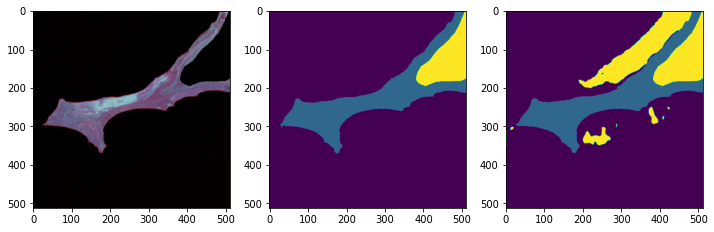

0.9207909694980386
(512, 512) (512, 512)
{0: 0.9956054309387987, 1: 0.9655553323960635}


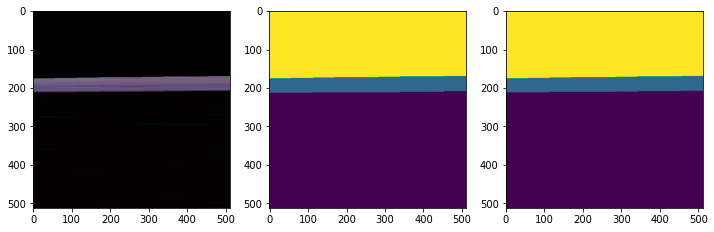

0.996090565691126
(512, 512) (512, 512)
{0: 0.9116139459709074, 1: 0.8946975539340729, 2: 0.03276274618074729}


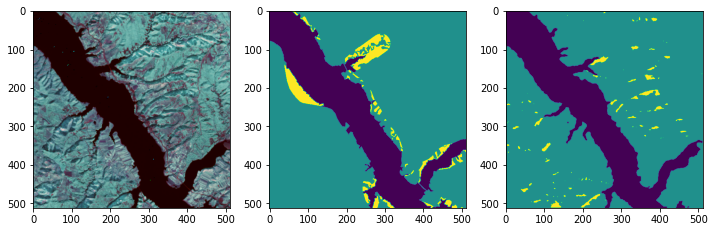

0.9183502197265625
(512, 512) (512, 512)
{0: 0.9209780026059631, 1: 0.8229759652501464, 2: 0.0493360427200983}


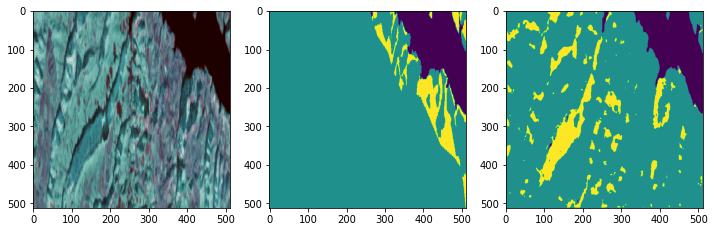

0.8397293090820312
(512, 512) (512, 512)
{0: 0.9413445108927808, 1: 0.8647790104732674, 2: 0.05314979447471561}


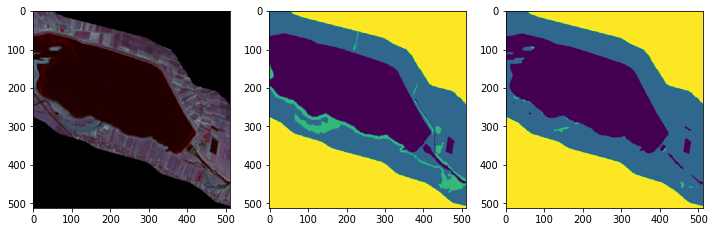

0.9180000639774799
(512, 512) (512, 512)
{0: 0.8825752855659398, 1: 0.7978622845924526, 2: 0.7154917112026415}


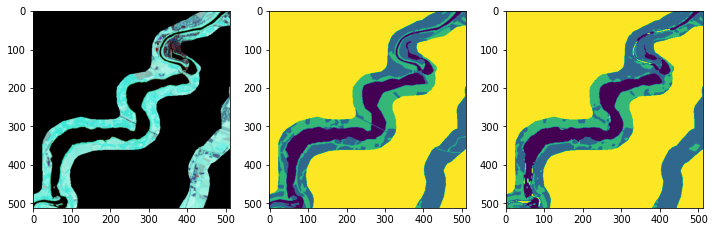

0.8789880402632779
(512, 512) (512, 512)
{0: 0.6721728081321474, 1: 0.9647797731442422, 2: 0.8274876776912636}


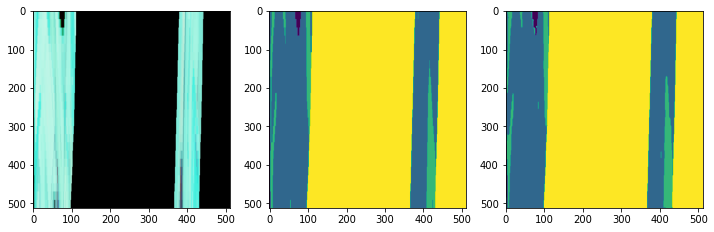

0.9681937187739376
(512, 512) (512, 512)
{0: 0.9227718284322058, 1: 0.2961320522296132, 2: 0.7839643993149009}


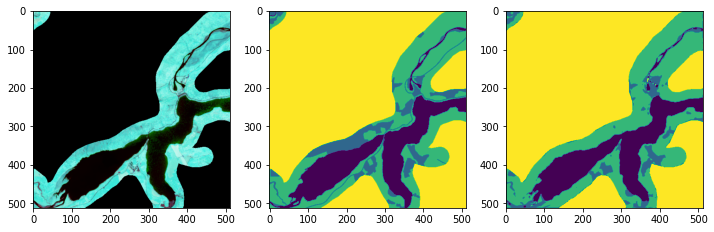

0.852333203684555
(512, 512) (512, 512)
{0: 0.8807811996995386, 1: 0.22538893139505228, 2: 0.7888102872071522}


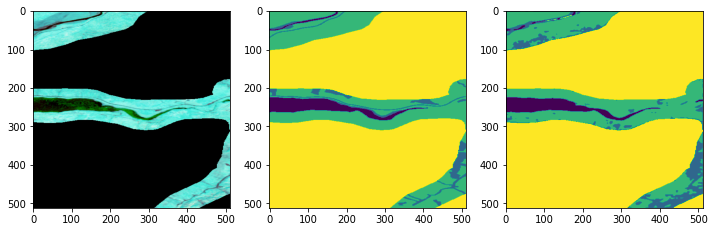

0.8182329057727701
(512, 512) (512, 512)
{0: 0.02040816326530612, 1: 0.22337790985636455, 2: 0.8652855558830548}


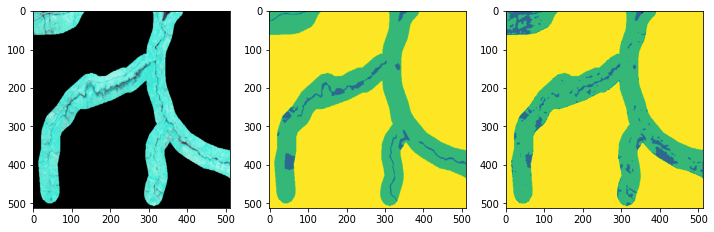

0.8703530907271424
(512, 512) (512, 512)
{1: 0.3262952979934112, 2: 0.86059670781893}


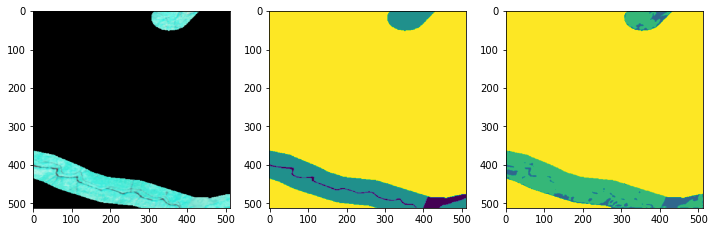

0.8704303826255045
(512, 512) (512, 512)
{0: 0.21089038666193685, 1: 0.7017353336318853, 2: 0.537348179687859}


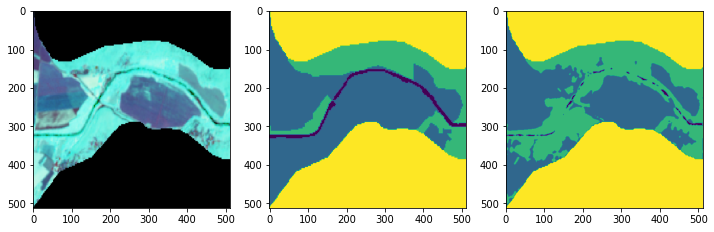

0.7634537192059316
(512, 512) (512, 512)
{0: 0.9165869828520431, 1: 0.8707170509042584, 2: 0.5233064014916097}


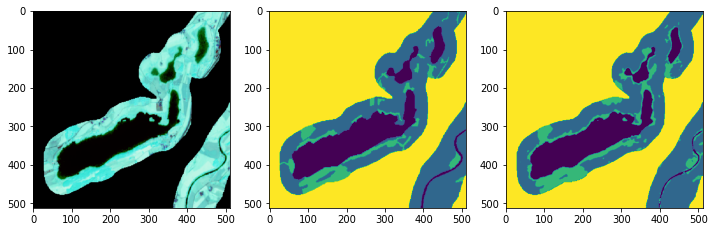

0.9025836854078648
0.6834349938651444 0.8859638364950941


In [ ]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import confusion_matrix

model.eval()

ious = []
accs = []
dictvaluesf = {}
cmf = np.zeros((4,4))
for batch_i, (x, y) in enumerate(test_dataloader):
    for j in range(len(x)):
        result = model(x.to(device)[j:j+1])
        mask = torch.argmax(result, axis=1).cpu().detach().numpy()[0]
        im = np.moveaxis(x.to(device)[j].cpu().detach().numpy(), 0, -1).copy()*255
        im = im.astype(int)
        gt_mask = y[j].numpy()

        values = np.unique(gt_mask)
        values = values[values>0]
        true = 0
        maskAux = gt_mask == 4
        maskAux = np.bitwise_and(maskAux, mask==4)
        for item in range(0,3):
          aux = mask == item
          aux[maskAux] = 0
          auxRef = gt_mask == item
          auxRef[maskAux] = 0
          true += np.sum(aux[auxRef == 1])
        all = np.sum(gt_mask<3)
        print(gt_mask.shape, mask.shape)
        cm = confusion_matrix(gt_mask.flatten(), mask.flatten(), labels=[0,1,2,3])
        cmf += cm


        miou, dictvalues = mIOU(gt_mask[:,:], mask, maskAux, 4)
        ious.append(miou)
        print(dictvalues)
        for key in dictvalues.keys():
          if(key in dictvaluesf):
            dictvaluesf[key].append(dictvalues[key])
          else:
            dictvaluesf[key] = [dictvalues[key]]

        accs.append(true/all)

        plt.figure(figsize=(12,12))

        plt.subplot(1,3,1)
        im = np.moveaxis(x.to(device)[j].cpu().detach().numpy(), 0, -1).copy()*255
        im = im.astype(int)
        plt.imshow(im[:,:,0:3])

        plt.subplot(1,3,2)
        plt.imshow(gt_mask*255)

        plt.subplot(1,3,3)
        plt.imshow(mask)
        plt.show()
        print(true/all)
        #io.imsave(os.path.join('drive/MyDrive/saved_models_transform/', str(j) +'.png'), gt_mask*60)
        

print(np.mean(ious), np.mean(accs))


        

In [ ]:
for key in dictvaluesf:
  print(dictvaluesf[key])
  print(key, np.average(dictvaluesf[key]))

[0.9084384847096711, 0.9956054309387987, 0.9116139459709074, 0.9209780026059631, 0.9413445108927808, 0.8825752855659398, 0.6721728081321474, 0.9227718284322058, 0.8807811996995386, 0.02040816326530612, 0.21089038666193685, 0.9165869828520431]
0 0.7653472524772701
[0.9664774030740996, 0.9655553323960635, 0.8946975539340729, 0.8229759652501464, 0.8647790104732674, 0.7978622845924526, 0.9647797731442422, 0.2961320522296132, 0.22538893139505228, 0.22337790985636455, 0.3262952979934112, 0.7017353336318853, 0.8707170509042584]
1 0.6862133768365329
[0.03276274618074729, 0.0493360427200983, 0.05314979447471561, 0.7154917112026415, 0.8274876776912636, 0.7839643993149009, 0.7888102872071522, 0.8652855558830548, 0.86059670781893, 0.537348179687859, 0.5233064014916097]
2 0.5488672276066339
